In [5]:
%load_ext autoreload
%matplotlib inline

In [6]:
%autoreload 2

import numpy as np
import sys,os,glob
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import xarray as xr

## Add own library to path
workdir = os.getcwd()
repodir = workdir
while os.path.basename(repodir) != 'Fildier2020':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from statisticalDistributions import *
# from plot1DInvLog import *
from importingData import *
from savingResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

repo: /global/cscratch1/sd/bfildier/dataAnalysis/Fildier2020
Own modules available: ['thermoConstants', 'setEnv', 'thermoFunctions', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'conditionalstats', 'dataFormat', 'savingResults', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'slicingAndSubsetting', 'thermoFunctionsForMoistAdiabat', 'plot2D']


In [7]:
fromsimname=True

if fromsimname: # Extract simulation attributes from simname
    
    simname = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2-b100-radagg"
    print("Simulation name:",simname)
    chunks = simname.split('_')
    case = chunks[0]
    Nxyz = chunks[3]
    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
    simroot = '_'.join(chunks[:4])
    expname = chunks[4]
    expchunks = expname.split('-')
    SST = int([expchunk[-3:] for expchunk in expchunks if re.match("SST*",expchunk)][0])

else: # Define simname from simulation attributes

    case = 'RCE'
    Nxyz = '256x256x64'
    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
    simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
    # Experiment name
    SST = 304
#     expname = "TKE-SST%d-r1"%SST
#     expname = "TKE-SST%d-radhomo-r1"%SST
#     expname = "TKE-SST%d-r1-b150-sfcagg"%SST
    expname = "TKE-SST%d-radhomo-r1-b100-radagg"%SST
#     expname = "TKE-SST%d-r1-b150-tkzfd4"%SST
    # Simulation full name
    simname = "%s_%s"%(simroot,expname)
    print("Simulation name:",simname)

Simulation name: RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2-b100-radagg


In [8]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [9]:
figdir = os.path.join(figuredir,simroot,expname)
if not os.path.exists(figdir): os.makedirs(figdir)

In [10]:
filepattern_2D = os.path.join(archivedir,simname,"OUT_2D","%s_%s.2Dcom_*.nc"%(simname,Nproc))
filepattern_STAT = os.path.join(archivedir,simname,"OUT_STAT","%s.nc"%(simname))
varids = ['PW','Prec']
ds_2D = xr.open_mfdataset(filepattern_2D,decode_cf=False,data_vars=varids)
# ds_STAT = xr.open_mfdataset(filepattern_STAT,decode_cf=False,data_vars=varids)

# Prec & PW stats

In [11]:
doSpatStats = False

In [12]:
figsubdir_spatstats= os.path.join(figdir,'xy_stats')
if not os.path.exists(figsubdir_spatstats): os.makedirs(figsubdir_spatstats)

In [13]:
if doSpatStats:

    print("Plot PW mean")
    # pw_mean = ds_STAT.PW
    # pr_mean = ds_STAT.PREC

    for varid in 'PW','PREC':

        fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,5))

        if varid == 'PREC':
            n = 48
            y2plot = np.convolve(ds_STAT[varid],[1/n]*n,mode='same')
            ax.plot(ds_STAT.time,y2plot,label='with 2-day filter')
            ax.legend()
        else:
            ax.plot(ds_STAT[varid])
        ax.set_xlabel('time (hours)')
        ax.set_ylabel(r'%s (mm)'%varid)

        plt.savefig(os.path.join(figsubdir_spatstats,'%s_over_time.pdf'%(varid)),bbox_layout='tight')
        plt.show()

In [14]:
if doSpatStats:

    print("Plot PW and Prec variance")
    # pw_var = ds_2D.PW.var(axis=(1,2))
    # pr_var = ds_2D.Prec.var(axis=(1,2))

    spatvar_dict = {}

    for varid in 'PW','Prec':

        spatvar_dict[varid] = ds_2D[varid].var(axis=(1,2))

        fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,5))

        ax.plot(spatvar_dict[varid])
        ax.set_xlabel('time (hours)')
        ax.set_ylabel(r'var(%s) (mm$^2$)'%varid)

        plt.savefig(os.path.join(figsubdir_spatstats,'var_%s_over_time.pdf'%(varid)),bbox_layout='tight')
        plt.show()

In [15]:
print("> Save spatial variance")

resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
if not os.path.exists(resultsubdir): os.makedirs(resultsubdir)

if doSpatStats:
    save2object(spatvar_dict,os.path.join(resultsubdir,'spatial_variances.pickle'))

> Save spatial variance


# 2D snapshots

In [16]:
do2DSnapshots = False

In [17]:
figsubdir_2D = os.path.join(figdir,'2D_snapshots')
if not os.path.exists(figsubdir_2D): os.makedirs(figsubdir_2D)

In [18]:
if do2DSnapshots:

    varid = 'PW'

    figshape = (3,3)
    fig = plt.figure(figsize=(6*figshape[0]-1,6*figshape[1]-1))

    # Ts = [200,1000,3000,3500,4000,4500]
#     Tmax = ds_STAT.dims['time']
    Tmax = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
    Ts = np.arange(240,Tmax,240)

    # for i in range(len(Ts)):
    for i in range(min(9,len(Ts))):
    #     j = len(Ts)-9+i
        j = i
        ax = fig.add_subplot(3,3,i+1)
        plt.imshow(ds_2D[varid][Ts[j]],cmap=plt.cm.viridis_r,
                   vmin=np.min(ds_2D[varid].data),vmax=np.max(ds_2D[varid].data),
                   origin='lower')
        plt.title('PW, t = %d days'%(Ts[j]/24))
    #     plt.xlabel('x (km)')
    #     plt.ylabel('y (km)')

    plt.savefig(os.path.join(figsubdir_2D,'%s_over_time.pdf'%(varid)),bbox_layout='tight')
    plt.show()

In [19]:
if do2DSnapshots:

    varid = 'PW'
    
#     NT = min(ds_STAT.dims['time'],ds_2D.dims['time'])
    NT = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
    Ts = np.arange(240,NT,240)

    cmap = plt.cm.viridis_r
    # cmap = plt.cm.gnuplot
    # cmap = plt.cm.Spectral

    for T in Ts:

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        plt.imshow(ds_2D[varid][T],cmap=cmap,
                   vmin=np.min(ds_2D[varid][T].data),vmax=np.max(ds_2D[varid][T].data),
                   origin='lower')
    #     plt.title('%s, t = %d days'%(varid,T/24))
        plt.savefig(os.path.join(figsubdir_2D,'%s_day%d.pdf'%(varid,T)),bbox_layout='tight')
        plt.close()


# Distributions PW over time

In [20]:
computeTimeEvolution = False

In [21]:
figsubdir_distrib = os.path.join(figdir,'distributions')
if not os.path.exists(figsubdir_distrib): os.makedirs(figsubdir_distrib)

In [22]:
# NT = min(ds_STAT.dims['time'],ds_2D.dims['time'])
NT = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
Ts = np.arange(240,NT,240)

colorInd = range(len(Ts))
cm = plt.get_cmap('jet') 
cNorm = colors.Normalize(vmin=0, vmax=colorInd[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

varid = 'PW'

if computeTimeEvolution:

    fig,ax = plt.subplots(figsize=(5,5))

    perc_pw_all = {}
    # Initialize storage
    ranks_pw_all = {}
    bins_pw_all = {}
    densities_pw_all = {}

    dt = 10 # ndays moving window to compute statistics


    for i in range(len(Ts)):

        T = Ts[i]
        sT = slice(T-dt/2*24,T+dt/2*24)
        colorVal = scalarMap.to_rgba(colorInd[i])

        ranks_l_pw, perc_l_pw, bins_l_pw, densities_pw = compute1dDensities(ds_2D[varid].data[sT],mode='linear')
        # Store results
        ranks_pw_all["%d"%T] = ranks_l_pw
        perc_pw_all["%d"%T] = perc_l_pw
        bins_pw_all["%d"%T] = bins_l_pw
        densities_pw_all["%d"%T] = densities_pw
        # Plot
        plt.plot(perc_l_pw,densities_pw,color=colorVal,label='t=%d days'%(T/24))

    plt.xscale('log')
    plt.xlabel(varid)
    plt.ylabel('PDF')
    ax.legend(fontsize=11)
    plt.savefig(os.path.join(figsubdir_distrib,'pdf_%s_over_time.pdf'%(varid)),bbox_layout='tight')
    plt.show()

In [23]:
print("save PW pdf")

resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
if not os.path.exists(resultsubdir): os.makedirs(resultsubdir)

if computeTimeEvolution:
    save2object(ranks_pw_all,os.path.join(resultsubdir,'ranks_pw.pickle'))
    save2object(perc_pw_all,os.path.join(resultsubdir,'percentiles_pw.pickle'))
    save2object(bins_pw_all,os.path.join(resultsubdir,'bins_pw.pickle'))
    save2object(densities_pw_all,os.path.join(resultsubdir,'densities_pw.pickle'))

save PW pdf


# PDF/CDFs of rain

## Percentiles and error ranges

In [24]:
varid = 'Prec'
ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(ds_2D[varid].data[slice(0,240)],mode='invlogQ')
Qmax = 99.99
iQmax = indexOfRank(Qmax,ranks_ILQ_pr)
iQ999 = indexOfRank(99.9,ranks_ILQ_pr)
sQ = slice(0,iQmax+1)
sQext = slice(iQ999,iQmax+1)

In [25]:
N_days = 50 # days
# N_days = 20 # days

In [26]:
randomTimeSlices = False

if randomTimeSlices:
    print("Compute PDF of rain over the last 30 days by aggregating n time slices m times + compute error range")
    print()
    print('Randomly select the time slices')
    print()
    varid = 'Prec'
    m_iter = 20
    NTmax = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
    NT_ref = N_days*24 # days
    pr_end = ds_2D[varid].data[NTmax-NT_ref:NTmax]

    n_slices = 20
    n_slices_all = np.arange(4,26,4)

    perc_mean_all_random = []
    bins_mean_all_random = []
    perc_std_all_random = []
    for n_slices in n_slices_all:
        print('# time slices = %d'%n_slices)

        perc_all = []
        bins_all = []
        for i in range(m_iter):
            print(i,end=' ')
            ind = np.random.choice(NT_ref,n_slices)
            pr = np.take(pr_end,ind,axis=0) ## line that take the most compute time
            ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(pr,mode='invlogQ')
            perc_all.append(perc_ILQ_pr[sQ])
            bins_all.append(bins_ILQ_pr[sQ])

        perc_mean_all_random.append(np.mean(perc_all,axis=0))
        bins_mean_all_random.append(np.mean(bins_all,axis=0))
        perc_std_all_random.append(np.std(perc_all,axis=0))

        print()

In [27]:
if randomTimeSlices:

    i999 = indexOfRank(99.9, ranks_ILQ_pr)
    perc_mean_999 = np.vstack(perc_mean_all_random)[:,i999]
    perc_std_999 = np.vstack(perc_std_all_random)[:,i999]

    fig,ax = plt.subplots(ncols=1,figsize=(5,5))

    ax.fill_between(x=n_slices_all,y1=perc_mean_999+perc_std_999,
                    y2=perc_mean_999-perc_std_999,alpha=0.5,color='r',label=r'$\sigma$')
    ax.plot(n_slices_all,perc_mean_999,'k',label=r'$\mathbb{E}(P^{99.9})$')

    ax.set_xlabel('# of time slices picked at random')
    ax.set_ylabel(r'99.9$^{th}$ percentile (mm/day)')
    ax.legend(fontsize=12)

    plt.savefig(os.path.join(figsubdir_distrib,'P999_err_vs_nslices_random_last50days.pdf'),bbox_layout='tight')
    plt.show()

In [ ]:
print("Compute PDF of rain over the last n_days days by aggregating n time slices m times + compute error range")
print()
print('Select consecutive time slices')
print()
varid = 'Prec'
m_iter = 20
NTmax = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
NT_ref = N_days*24 # days
pr_end = ds_2D[varid].data[NTmax-NT_ref:NTmax]

n_slices = 20
n_slices_all = np.arange(4,26,4)

perc_mean_all_consec = []
bins_mean_all_consec = []
perc_std_all_consec = []
cdf_mean_all_consec = []
cdf_std_all_consec = []

for n_slices in n_slices_all:
    print('# time slices = %d'%n_slices)

    perc_all = []
    bins_all = []
    cdf_all = []
    
    for i in range(m_iter):
        print(i,end=' ')
        ind = np.random.choice(NT_ref-n_slices,1)[0]
        pr = pr_end[ind:(ind+n_slices)]
        # Stats
        ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(pr,mode='invlogQ')
        # 1-CDF
        cdf_ILQ_pr = computeInvCDF(pr,ranks_ILQ_pr,perc_ILQ_pr)
        
        perc_all.append(perc_ILQ_pr)
        bins_all.append(bins_ILQ_pr)
        cdf_all.append(cdf_ILQ_pr)

    perc_mean_all_consec.append(np.mean(perc_all,axis=0))
    bins_mean_all_consec.append(np.mean(bins_all,axis=0))
    perc_std_all_consec.append(np.std(perc_all,axis=0))
    cdf_mean_all_consec.append(np.mean(cdf_all,axis=0))
    cdf_std_all_consec.append(np.std(cdf_all,axis=0))

    print()

Compute PDF of rain over the last n_days days by aggregating n time slices m times + compute error range

Select consecutive time slices

# time slices = 4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
# time slices = 8
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
# time slices = 12
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
# time slices = 16
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
# time slices = 20
0 1 2 

In [ ]:
showConsecTimeSlices = False

In [ ]:
if showConsecTimeSlices:

    i999 = indexOfRank(99.9, ranks_ILQ_pr)
    perc_mean_consec_999 = np.vstack([v[sQ] for v in perc_mean_all_consec])[:,i999]
    perc_std_consec_999 = np.vstack([v[sQ] for v in perc_std_all_consec])[:,i999]

    fig,ax = plt.subplots(ncols=1,figsize=(5,5))

    ax.fill_between(x=n_slices_all,y1=perc_mean_consec_999+perc_std_consec_999,
                    y2=perc_mean_consec_999-perc_std_consec_999,alpha=0.5,color='r',label=r'$\sigma$')
    ax.plot(n_slices_all,perc_mean_consec_999,'k',label=r'$\mathbb{E}(P^{99.9})$')

    ax.set_xlabel('# of time slices picked consecutively')
    ax.set_ylabel(r'99.9$^{th}$ percentile (mm/day)')
    ax.legend(loc='lower right',fontsize=12)

    plt.savefig(os.path.join(figsubdir_distrib,'P999_err_vs_nslices_consec_last50days.pdf'),bbox_layout='tight')
    plt.show()

In [ ]:
if randomTimeSlices:

    fig,ax = plt.subplots(ncols=1,figsize=(5,5))

    ax.fill_between(x=n_slices_all,y1=perc_mean_consec_999+perc_std_consec_999,
                    y2=perc_mean_consec_999-perc_std_consec_999,alpha=0.5,color='r',label=r'$\sigma$ consec')
    ax.plot(n_slices_all,perc_mean_consec_999,'k',label=r'$\mathbb{E}(P^{99.9})$ consec')

    ax.fill_between(x=n_slices_all,y1=perc_mean_999+perc_std_999,
                    y2=perc_mean_999-perc_std_999,alpha=0.5,color='b',label=r'$\sigma$ random')
    ax.plot(n_slices_all,perc_mean_999,'y',label=r'$\mathbb{E}(P^{99.9})$ random')

    ax.set_xlabel('# of time slices')
    ax.set_ylabel(r'99.9$^{th}$ percentile (mm/day)')
    # ax.legend(loc='lower right',fontsize=12)
    ax.legend(loc='upper right',fontsize=12)

    plt.savefig(os.path.join(figsubdir_distrib,'P999_err_vs_nslices_random&consec_last50days.pdf'),bbox_layout='tight')
    plt.show()

In [ ]:
if showConsecTimeSlices:

    fig,ax = plt.subplots(ncols=1,figsize=(5,5))

    i_n = 5

    ranks = ranks_ILQ_pr[sQ]
    subplotYShadingRanksILog(ax,ranks,[perc_mean_all_consec[i_n][sQ]-perc_std_all_consec[i_n][sQ],
                                       perc_mean_all_consec[i_n][sQ]+perc_std_all_consec[i_n][sQ]],
                             col='r',alpha=0.5,transformX=False)

    subplotRanksILog(ax,ranks,
                 [perc_mean_all_consec[i_n][sQ]],ltype=['-'],col=['k'],transformX=(i==m_iter-1))


    # Crop x-axis
    iQ_min = 8
    x = np.flipud(1./(1-ranks/100.))
    ax.set_xlim((x[iQ_min-1],0.8))

    ax.set_ylabel(r'Rain percentile $P^Q$ (mm/day)')
    ax.set_xlabel(r'Rain percentile rank $Q$')

    plt.savefig(os.path.join(figsubdir_distrib,'P999_err_vs_ranks_consec15_last50days.pdf'),bbox_layout='tight')
    plt.show()


In [ ]:
print("save pr end pdf and error")

resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
if not os.path.exists(resultsubdir): os.makedirs(resultsubdir)
    
# save2object(ranks_ILQ_pr_all,os.path.join(resultsubdir,'ranks_ILQ_pr.pickle'))
save2object(perc_mean_all_consec,os.path.join(resultsubdir,'mean_percentiles_consec_sample_ILQ_pr.pickle'))
save2object(cdf_mean_all_consec,os.path.join(resultsubdir,'mean_cdf_invlog_consec_sample_ILQ_pr.pickle'))
save2object(bins_mean_all_consec,os.path.join(resultsubdir,'mean_bins_consec_sample_ILQ_pr.pickle'))
save2object(perc_std_all_consec,os.path.join(resultsubdir,'std_percentiles_consec_sample_ILQ_pr.pickle'))
save2object(cdf_std_all_consec,os.path.join(resultsubdir,'std_cdf_invlog_consec_sample_ILQ_pr.pickle'))

if randomTimeSlices:
    save2object(perc_mean_all_random,os.path.join(resultsubdir,'mean_percentiles_random_sample_ILQ_pr.pickle'))
    save2object(perc_std_all_random,os.path.join(resultsubdir,'std_percentiles_random_sample_ILQ_pr.pickle'))

# save2object(bins_ILQ_pr_all,os.path.join(resultsubdir,'bins_ILQ_pr.pickle'))
# save2object(cdf_ILQ_pr_all,os.path.join(resultsubdir,'cdf_ILQ_pr.pickle'))

## Time series of percentiles

In [54]:
if computeTimeEvolution:

    print("Compute time series of the PDF of rain by aggregating n time slices")
    print()
    print('Select consecutive time slices')
    print()
    varid = 'Prec'
#     NTmax = floor(len(ds_2D.time)/10/24)*10*24 # pick the last day of the last full decade, and convert it to #hours
#     NT_ref = 50*24 # days
#     pr_end = ds_2D[varid].data[NTmax-NT_ref:NTmax]
    pr_all = ds_2D[varid].data[:]

    n_slices = 48
    # n_slices_all = np.arange(2,34,4)

    pr_perc_day_over_time_all = []

    #     for i in np.arange(0,ds_2D.dims['time'],n_slices):
    for i in np.arange(0,NT_ref-n_slices,n_slices):
            print(i,end=' ')
            pr = pr_all[NTmax-NT_ref+i:NTmax-NT_ref+(i+n_slices)]
            ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(pr,mode='invlogQ')
            pr_perc_day_over_time_all.append(perc_ILQ_pr[sQ])


Compute time series of the PDF of rain by aggregating n time slices

Select consecutive time slices

0 48 96 144 192 240 288 336 384 432 480 528 576 624 672 720 768 816 864 912 960 1008 1056 1104 

In [76]:
time_48h = np.take(ds_2D.time.values,range(NTmax-NT_ref,NTmax-n_slices,n_slices))
time_48h

array([ 100.04165649,  102.04165649,  104.04165649,  106.04165649,
        108.04165649,  110.04165649,  112.04165649,  114.04165649,
        116.04165649,  118.04165649,  120.04165649,  122.04165649,
        124.04165649,  126.04165649,  128.04167175,  130.04167175,
        132.04167175,  134.04167175,  136.04167175,  138.04167175,
        140.04167175,  142.04167175,  144.04167175,  146.04167175])

In [80]:
pw_mean = np.take(np.mean(ds_2D.PW.values,axis=(1,2)),range(NTmax-NT_ref,NTmax-n_slices,n_slices))
pw_mean

array([ 45.98726654,  45.65331268,  45.26367188,  45.34980774,
        46.57249069,  47.28741455,  47.12528229,  47.49488831,
        46.3332901 ,  45.37813187,  45.7936821 ,  45.97301483,
        45.58635712,  43.9359436 ,  43.32822037,  42.32199478,
        43.35483932,  44.10386276,  43.24251556,  43.62337494,
        44.44727707,  43.44997025,  42.33750916,  43.13518524], dtype=float32)

show evolution of extremes over the last 50 days of simulation, for a 48h accumulation


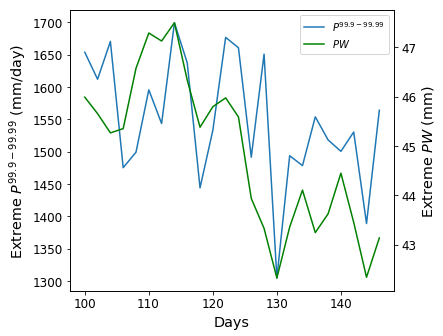

In [90]:
print('show evolution of extremes over the last 50 days of simulation, for a 48h accumulation')

pr_perc_day_over_time_prQ = [np.mean(perc[sQext]) for perc in pr_perc_day_over_time_all]

fig, ax = plt.subplots(figsize=(6,5))

c1 = ax.plot(time_48h,pr_perc_day_over_time_prQ,label=r'$P^{99.9-99.99}$')
ax2 = ax.twinx()
c2 = ax2.plot(time_48h,pw_mean,'g',label=r'$PW$')
ax.set_xlabel('Days')
ax.set_ylabel(r'Extreme $P^{99.9-99.99}$ (mm/day)')
ax2.set_ylabel(r'Extreme $PW$ (mm)')

# legend
lns = c1+c2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.savefig(os.path.join(figsubdir_distrib,'P999_9999_PW_vs_time_consec48_last50days.pdf'),bbox_layout='tight')

In [24]:
if computeTimeEvolution:

    print("Compute time series of the PDF of PW by aggregating n time slices")
    print()
    print('Select consecutive time slices')
    print()
    varid = 'PW'
    pw_all = ds_2D[varid].data[:]

    n_slices = 24
    # n_slices_all = np.arange(2,34,4)

    pw_dens_day_over_time_all = []

    for i in np.arange(0,ds_2D.dims['time'],n_slices):
        print(i,end=' ')
        pw = pw_all[i:(i+n_slices)]
        ranks_l_pw, perc_l_pw, bins_l_pw, densities_pw = compute1dDensities(pw,
                                                                        n_lin_bins=100,
                                                                        vmin=3,vmax=60,mode='linear')
        pw_dens_day_over_time_all.append(densities_pw)


Compute time series of the PDF of PW by aggregating n time slices

Select consecutive time slices

0 

/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


24 48 72 96 120 144 168 192 216 240 264 288 312 336 360 384 408 432 456 480 504 528 552 576 600 624 648 672 696 720 744 768 792 816 840 864 888 912 936 960 984 1008 1032 1056 1080 1104 1128 1152 1176 1200 1224 1248 1272 1296 1320 1344 1368 1392 1416 1440 1464 1488 1512 1536 1560 1584 1608 1632 1656 1680 1704 1728 1752 1776 1800 1824 1848 1872 1896 1920 1944 1968 1992 2016 2040 2064 2088 2112 2136 2160 2184 2208 2232 2256 2280 2304 2328 2352 2376 2400 2424 2448 2472 2496 2520 2544 2568 2592 2616 2640 2664 2688 2712 2736 2760 2784 2808 2832 2856 2880 2904 2928 2952 2976 3000 3024 3048 3072 3096 3120 3144 3168 3192 3216 3240 3264 3288 3312 3336 3360 3384 3408 3432 3456 3480 3504 3528 3552 3576 

In [25]:
if computeTimeEvolution:

    print("save pr end pw time series")

    resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
    if not os.path.exists(resultsubdir): os.makedirs(resultsubdir)

    save2object(ranks_ILQ_pr,os.path.join(resultsubdir,'ranks_for_consec24_ILQ_pr.pickle'))
    save2object(pr_perc_day_over_time_all,os.path.join(resultsubdir,'percentiles_consec24_ILQ_pr.pickle'))
    save2object(pw_dens_day_over_time_all,os.path.join(resultsubdir,'density_consec24_lQ_pw.pickle'))
    save2object(bins_l_pw,os.path.join(resultsubdir,'bins_for_consec24_lQ_pw.pickle'))



save pr end pw time series


### GIFs

In [71]:
figsubdir_distrib_gifs = os.path.join(figdir,'distributions','gifs')
if not os.path.exists(figsubdir_distrib_gifs): os.makedirs(figsubdir_distrib_gifs)

In [72]:
if computeTimeEvolution:

    print("Create gif ")

    Ndays_end = 50
    NT_end = Ndays_end*24

    i_T = 20

    for i_T in range(ds_2D.dims['time']//24-Ndays_end,ds_2D.dims['time']//24):

        print(i_T,end=' ')

        fig,ax = plt.subplots(ncols=2,figsize=(11,5))

        ax[0].set_ylim((-30,1030))
        ax[1].set_ylim((-0.003,0.103))

        ranks = ranks_ILQ_pr[sQ]
        # subplotYShadingRanksILog(ax,ranks,[perc_mean_all_consec[i_n]-perc_std_all_consec[i_n],
        #                                    perc_mean_all_consec[i_n]+perc_std_all_consec[i_n]],
        #                          col='r',alpha=0.5,transformX=False)

        subplotRanksILog(ax[0],ranks,
                     [pr_perc_day_over_time_all[i_T]],ltype=['-'],col=['k'],transformX=True)

        ax[0].set_ylabel(r'Rain percentile $P^Q$ (mm/day)')
        ax[0].set_xlabel(r'Rain percentile rank $Q$')

        # Crop x-axis
        iQ_min = 8
        x = np.flipud(1./(1-ranks/100.))
        ax[0].set_xlim((x[iQ_min-1],0.8))

        ax[1].plot(perc_l_pw,pw_dens_day_over_time_all[i_T],'b')
        ax[1].set_ylabel(r'Probability density')
        ax[1].set_xlabel(r'PW (mm)')

        plt.savefig(os.path.join(figsubdir_distrib_gifs,'pr_vs_ranks_and_pw_pdf_%d_last%ddays.pdf'%(i_T,Ndays_end)),bbox_layout='tight')
        plt.close()



In [73]:
if computeTimeEvolution:

    print("Draw percentiles vs. time")

    i999 = indexOfRank(99.9, ranks_ILQ_pr)
    pr_perc_day_over_time_999 = np.vstack(pr_perc_day_over_time_all)[:,i999]

    day_0 = ds_2D['time'][0]
    ndays = ds_2D.dims['time']/24
    time = np.arange(day_0,day_0+ndays)

    fig,ax = plt.subplots(ncols=1,figsize=(5,5))

    ax.plot(time,pr_perc_day_over_time_999,'k')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$P^{99.9}$ (mm/day)')

    plt.savefig(os.path.join(figsubdir_distrib,'P999_over_time_consec24.pdf'),bbox_layout='tight')

## Time evolution of PDFs

In [74]:
computeTimeEvolution = False

In [75]:
if computeTimeEvolution:

    varid = 'Prec'

    print("Compute PDF of rain every 10 days by aggregating hourly properties")

    # ref axis
    ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(ds_2D[varid].data[slice(0,10)],mode='invlogQ')

    NT = min(ds_STAT.dims['time'],ds_2D.dims['time'])
    Ts = np.arange(240,NT,240)
    dt = 10 # ndays moving window to compute statistics

    ranks_ILQ_pr_all = {}
    perc_ILQ_pr_all = {}
    bins_ILQ_pr_all = {}
    cdf_ILQ_pr_all = {}

    for i in range(len(Ts)):

        T = Ts[i]
        sT = slice(T-dt/2*24,T+dt/2*24)

        # PDF
        ranks_ILQ_pr, perc_ILQ_pr, bins_ILQ_pr = ranksPercentilesAndBins(ds_2D[varid].data[sT],mode='invlogQ')

        # 1-CDF
        cdf_ILQ_pr = computeInvCDF(ds_2D[varid].data[sT],ranks_ILQ_pr,perc_ILQ_pr)

        ranks_ILQ_pr_all["%d"%T] = ranks_ILQ_pr
        perc_ILQ_pr_all["%d"%T] = perc_ILQ_pr
        bins_ILQ_pr_all["%d"%T] = bins_ILQ_pr
        cdf_ILQ_pr_all["%d"%T] = cdf_ILQ_pr

In [76]:
if computeTimeEvolution:
    varid = 'Prec'

    colorInd = range(len(Ts))
    cm = plt.get_cmap('jet') 
    cNorm = colors.Normalize(vmin=0, vmax=colorInd[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    fig,ax = plt.subplots(ncols=1,figsize=(6,5))

    for i in range(len(Ts)):

        T = Ts[i]
        colorVal = scalarMap.to_rgba(colorInd[i])

        # PDF
        subplotRanksILog(ax,ranks_ILQ_pr_all["%d"%T][sQ],
                     [perc_ILQ_pr_all["%d"%T][sQ]],ltype=['-'],col=[colorVal],
                     labels=['t=%d days'%(T/24)],transformX=(T==Ts[-1]))

    # ax[0].set_yscale('log')
    ax.set_ylabel(r'Rain percentile $P^Q$ (mm/day)')
    ax.set_xlabel(r'Rain percentile rank $Q$')

    ax.legend(fontsize=11)

    plt.savefig(os.path.join(figsubdir_distrib,'pdf_%s_over_time.pdf'%(varid)),bbox_layout='tight')
    plt.show()

In [77]:
if computeTimeEvolution:

    colorInd = range(len(Ts))
    cm = plt.get_cmap('jet') 
    cNorm = colors.Normalize(vmin=0, vmax=colorInd[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    fig,ax = plt.subplots(ncols=1,figsize=(6,5))

    for i in range(len(Ts)):

            T = Ts[i]
            colorVal = scalarMap.to_rgba(colorInd[i])

            # 1-CDF
            subplotRanksILog(ax,ranks_ILQ_pr_all["%d"%T][sQ],
                         [cdf_ILQ_pr_all["%d"%T][sQ]],
                         col=[colorVal],ltype=['-'],
                         labels=['t=%d days'%(T/24)],transformX=(T==Ts[-1]))

    ax.set_title("1-CDF(P)")
    ax.set_xlabel(r'Rain percentile rank $Q$ (%)')
    ax.set_ylabel(r'Fraction of rain above $P^Q$')

    ax.legend(fontsize=11)

    plt.savefig(os.path.join(figsubdir_distrib,'cdfinv_%s_amounts_over_time.pdf'%(varid)),bbox_layout='tight')
    plt.show()

In [78]:
if computeTimeEvolution:

    print("save pr pdfs")

    resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
    if not os.path.exists(resultsubdir): os.makedirs(resultsubdir)

    save2object(ranks_ILQ_pr_all,os.path.join(resultsubdir,'ranks_ILQ_pr.pickle'))
    save2object(perc_ILQ_pr_all,os.path.join(resultsubdir,'percentiles_ILQ_pr.pickle'))
    save2object(bins_ILQ_pr_all,os.path.join(resultsubdir,'bins_ILQ_pr.pickle'))
    save2object(cdf_ILQ_pr_all,os.path.join(resultsubdir,'cdf_ILQ_pr.pickle'))